In [1]:
import re
import requests
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
import seaborn as sns
import pandas as pd
import datetime
import pyarrow


In [2]:
#objetio Analise cotação do cafe
#estapas
# coletar preço do cafe
# extruturar dados
# plotar graficos

In [3]:
url = 'http://portalweb.cooxupe.com.br:8080/portal/precohistoricocafe.jsp'
page = requests.get(url)

In [4]:
parser = BeautifulSoup(page.text, "html.parser")

In [5]:
tables = parser.select('Table')

In [6]:
months = []
for children in tables[0].find_all('thead')[0].children:
    for i  in children:
        try:
            month = i.getText()
            if month != 'Ano' and month != '\n':
                months.append(i.getText())
        except AttributeError:
            pass

In [7]:
months

['Janeiro',
 'Fevereiro',
 'Março',
 'Abril',
 'Maio',
 'Junho',
 'Julho',
 'Agosto',
 'Setembro',
 'Outubro',
 'Novembro',
 'Dezembro']

In [8]:
list_df = []
for table in tables:
    dict_year_values = {}
    for children in table.find_all('tbody')[0].children:
        for i  in children:
            try:
                attrs = i.attrs
                value = i.getText().strip()
                if value != '' and value != '\n':
                    if attrs:
                        if attrs['class'][0] == 'r':
                            value = i.getText().strip()
                            if value != '':
                                dict_year_values[year].append(value)
                    else:
                        year = value
                        dict_year_values.setdefault(year, [])

            except AttributeError:
                pass
    df = pd.DataFrame.from_dict(dict_year_values,orient='index')
    df.columns = months
    list_df.append(df)
    

In [9]:
title = parser.select('Title')[0]
title = title.getText()

In [10]:
title

'Preço Histórico do Café'

In [11]:
sub_titles = []
for sub_title in  parser.select('H2'):
    sub_title = sub_title.getText()
    if not 'href' in sub_title and  not 'pdf' in sub_title:
        sub_titles.append(sub_title)

In [12]:
sub_titles

['Preço Médio das Sacas de Café comercializado na Cooxupé em US$',
 'Preço Médio das Sacas de Café comercializado na Cooxupé em R$',
 'Quantidade de Sacas de Café comercializado na Cooxupé']

In [13]:
column_name = ['dolar', 'real', 'quantidade']

In [14]:
for i, df in enumerate(list_df):
    df = df.reset_index().rename(columns={'index': 'year'})
    
    df = df.melt(id_vars='year', value_vars=months)
    df.value = df.value.astype('float32')
    
    df.rename(columns={'variable': 'month', 'value': column_name[i]}, inplace=True)
    list_df[i] = df

In [15]:
df_merge = pd.DataFrame()
for df in list_df:
    if df_merge.empty:
        df_merge = df
    else:
        df_merge = pd.merge(left=df_merge, right=df, how='inner', on=['year', 'month'])

In [20]:
df_merge.to_parquet('teste.parquet', index=False)

In [24]:
pd.read_parquet('teste.parquet')

,year,month,dolar,real,quantidade
0,2023,Janeiro,199.830002,1.030140e+03,223440.0
1,2022,Janeiro,268.929993,1.480490e+03,291861.0
2,2021,Janeiro,119.570000,6.392300e+02,267095.0
3,2020,Janeiro,120.269997,5.016800e+02,153694.0
4,2019,Janeiro,107.040001,3.999800e+02,283410.0
...,...,...,...,...,...
511,1985,Dezembro,245.589996,2.449053e+06,76555.0
512,1984,Dezembro,85.989998,2.588990e+05,55460.0
513,1983,Dezembro,58.130001,5.495150e+04,74964.0
514,1982,Dezembro,99.919998,2.446128e+04,53137.0


In [39]:
def get_date(line):
    year = line.year
    month = str(months.index(line.month) + 1).zfill(2)
    day = '01'
    _date_str = f'{year}-{month}-{day}'
    _date =  datetime.date.fromisoformat(_date_str)
    return _date

In [40]:
df_merge['date'] = df_merge.apply(get_date,axis=1)

In [41]:
df_merge.describe().round(2)

,dolar,real,quantidade
count,505.00,505.00,505.00
mean,119.48,73713.10,236421.30
std,56.78,372670.31,242617.17
min,35.04,90.68,125.77
25%,73.86,212.85,86669.00
50%,112.39,430.47,149368.00
75%,149.91,3464.15,291861.00
max,319.37,4056066.00,2089208.00


In [42]:
df_merge['year'] = df_merge.year.astype(int)

In [43]:

df_merge['date'] = pd.to_datetime(df_merge.date)

In [44]:
df_merge['mounth'] = df_merge.date.dt.month

In [67]:
#removi dados sujeitos a Hiperinflação e troca de moeda
df_merge = df_merge.query('year > 1994')

In [68]:
df_merge.dropna(inplace=True)

In [69]:
df_merge.describe().round(2)

,year,dolar,real,quantidade,mounth
count,337.00,337.00,337.00,337.00,337.00
mean,2008.54,133.63,344.73,311777.34,6.48
std,8.12,55.18,245.71,265218.50,3.47
min,1995.00,35.04,90.68,49826.00,1.00
25%,2002.00,102.47,181.57,140166.00,3.00
50%,2009.00,126.92,264.85,225194.00,6.00
75%,2016.00,160.15,450.84,379993.00,9.00
max,2023.00,319.37,1488.11,2089208.00,12.00


In [1]:
df_merge

NameError: name 'df_merge' is not defined

In [70]:
df_merge.corr()

,year,dolar,real,quantidade,mounth
year,1.000000,0.345650,0.793829,0.490993,-0.008415
dolar,0.345650,1.000000,0.570736,0.095570,-0.081086
real,0.793829,0.570736,1.000000,0.300690,-0.011382
quantidade,0.490993,0.095570,0.300690,1.000000,0.225705
mounth,-0.008415,-0.081086,-0.011382,0.225705,1.000000


<AxesSubplot:xlabel='date', ylabel='dolar'>

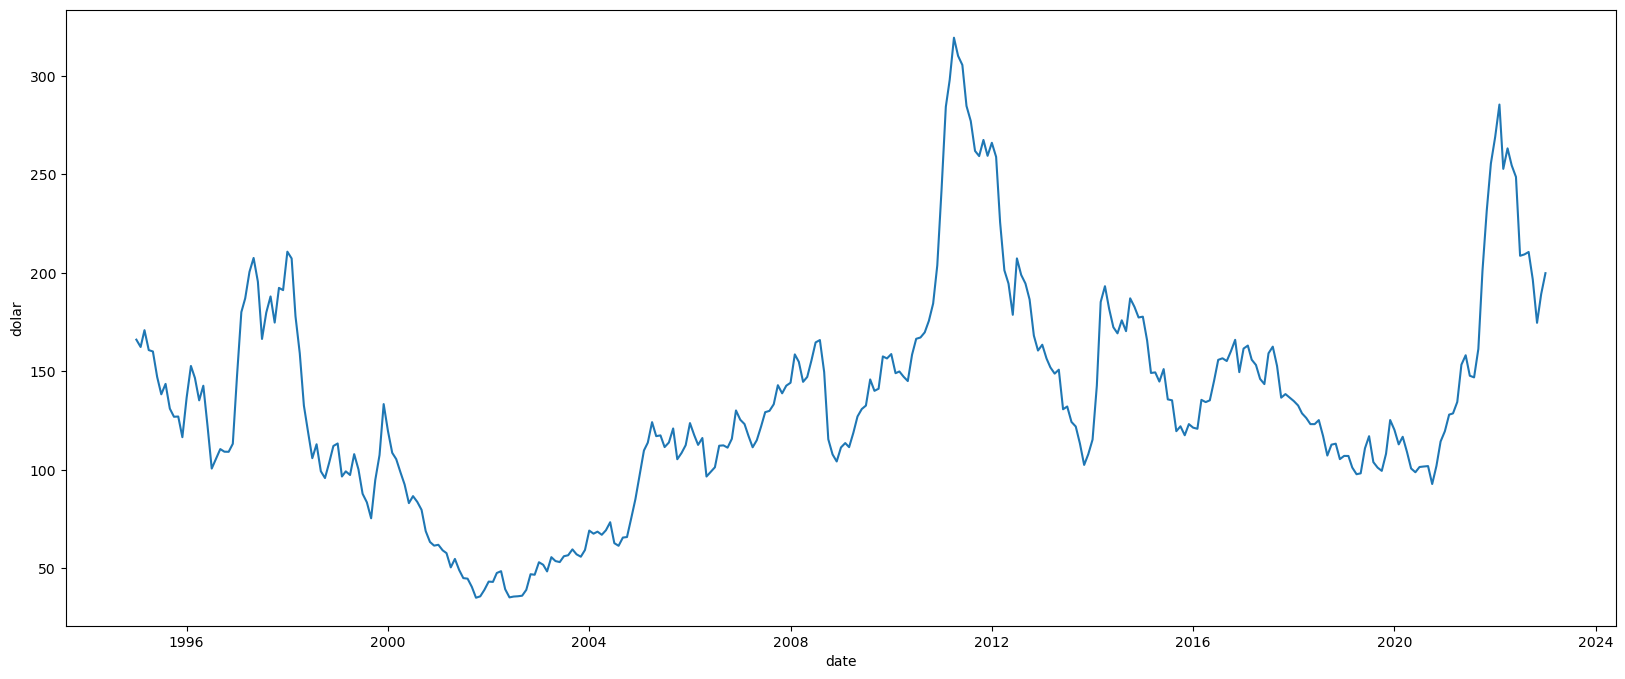

In [71]:
plt.figure(figsize=(20, 8))
sns.lineplot(data=df_merge, y='dolar', x='date')

<AxesSubplot:xlabel='date', ylabel='real'>

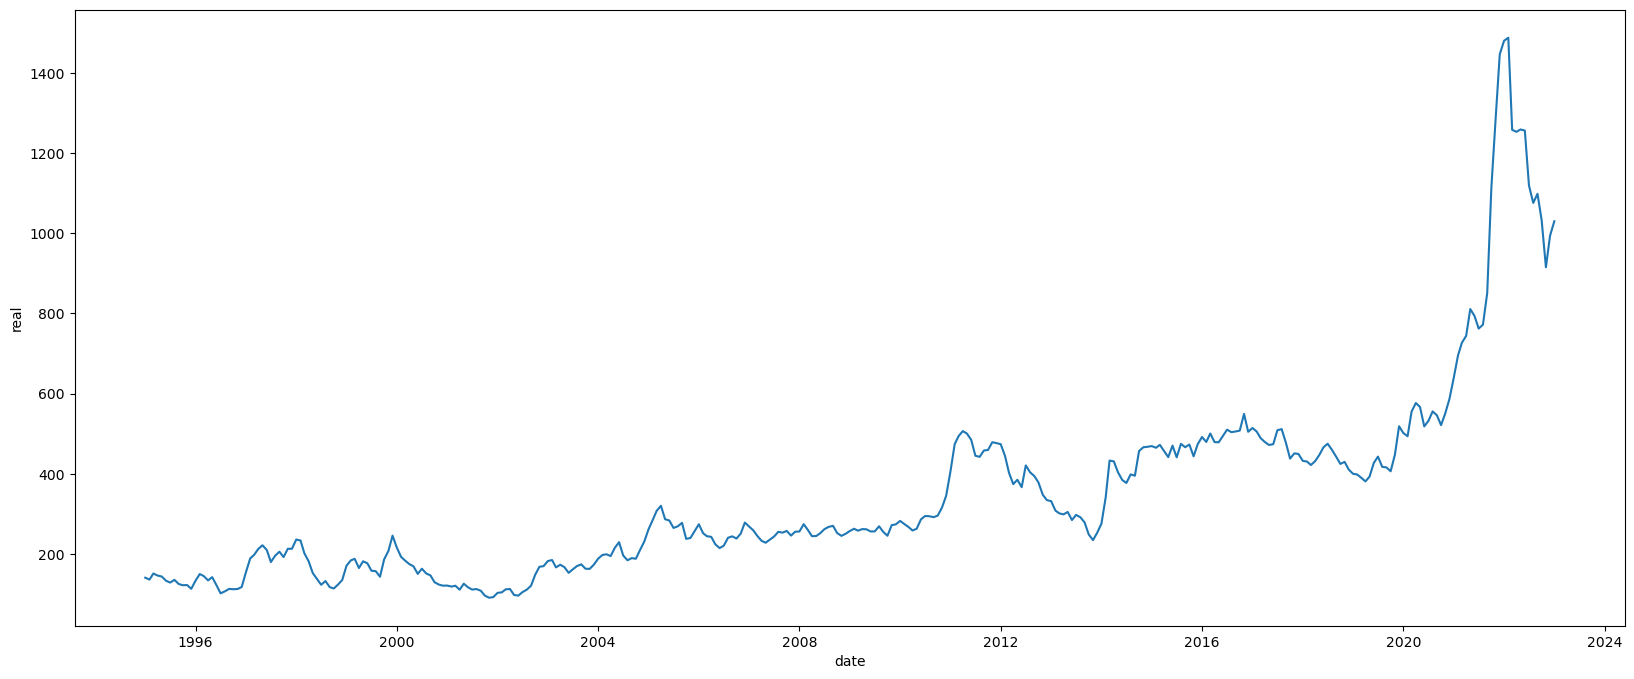

In [72]:
plt.figure(figsize=(20, 8))
sns.lineplot(data=df_merge, y='real', x='date')

<AxesSubplot:xlabel='date', ylabel='quantidade'>

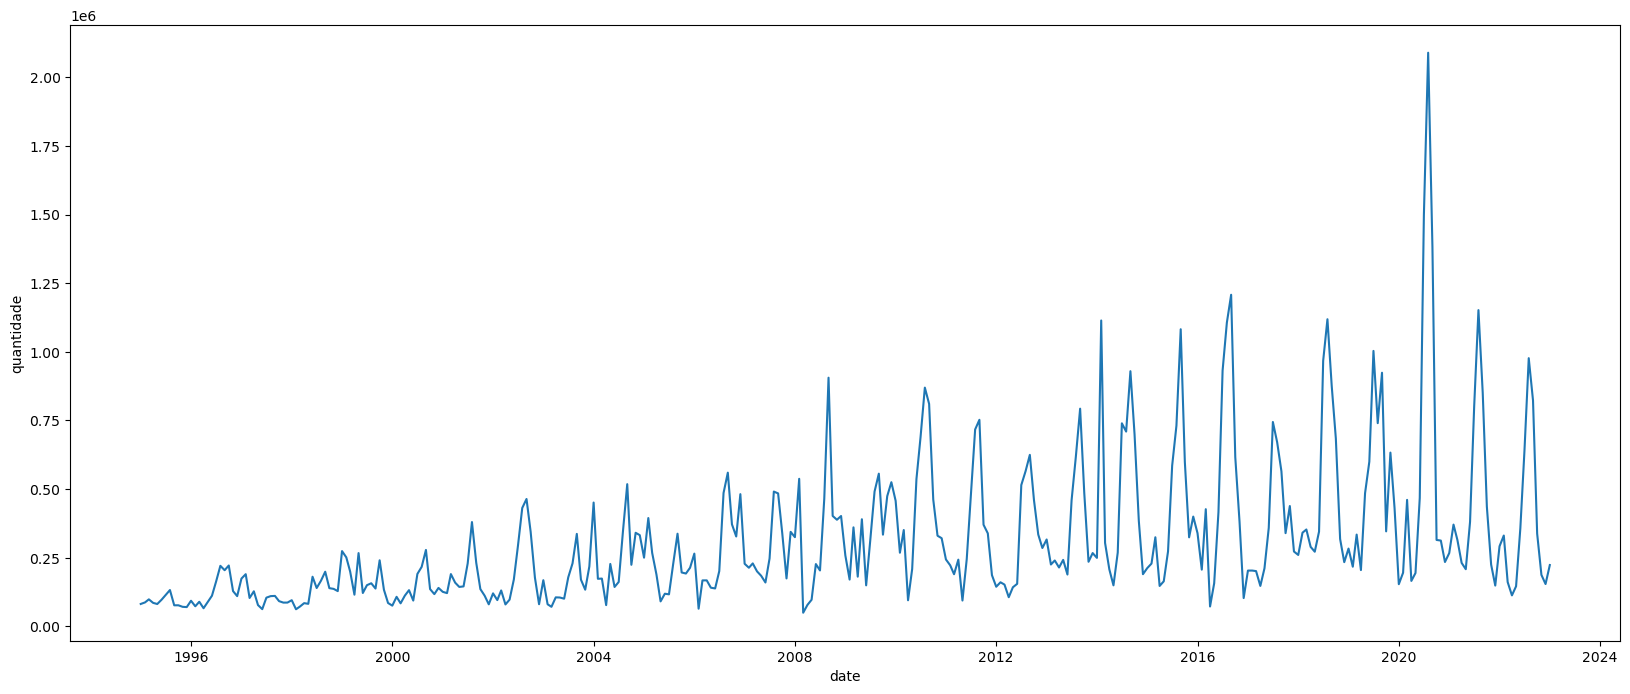

In [73]:
plt.figure(figsize=(20, 8))
sns.lineplot(data=df_merge, y='quantidade', x='date')

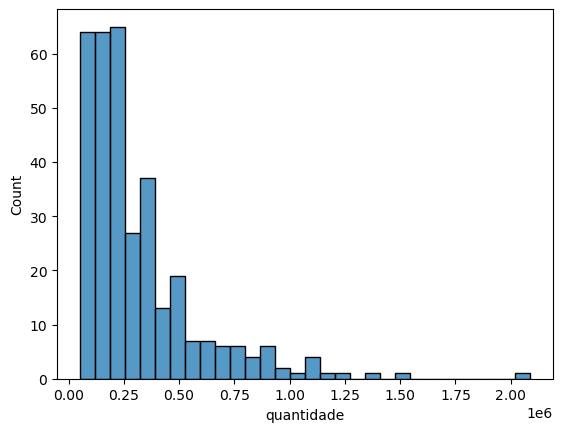

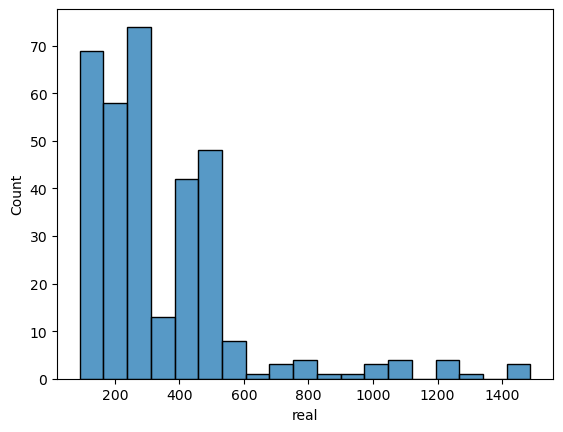

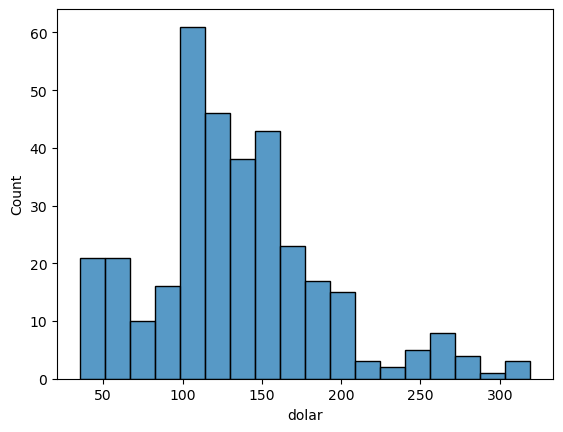

In [74]:
sns.histplot(data=df_merge, x='quantidade')
plt.show()
sns.histplot(data=df_merge, x='real');
plt.show()
sns.histplot(data=df_merge, x='dolar');

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

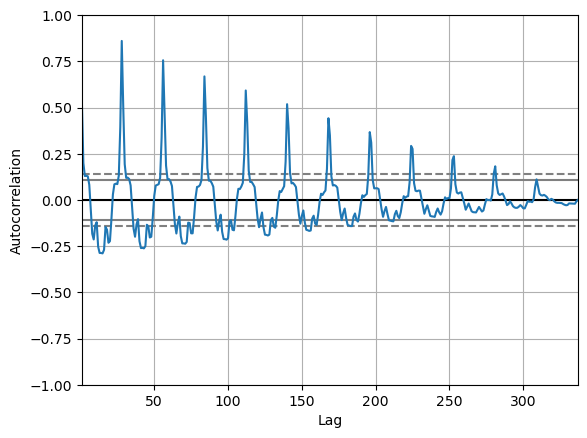

In [80]:
pd.plotting.autocorrelation_plot(df_merge['real'])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

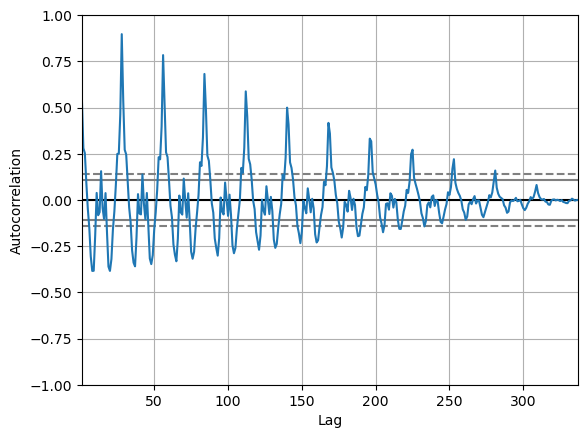

In [81]:
pd.plotting.autocorrelation_plot(df_merge['dolar'])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

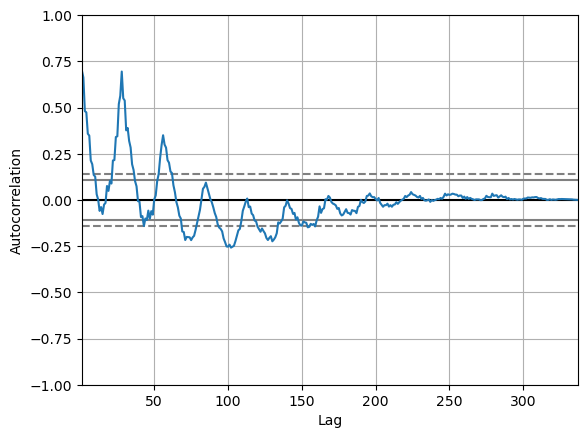

In [85]:
pd.plotting.autocorrelation_plot(df_merge['quantidade'])

<AxesSubplot:xlabel='month', ylabel='quantidade'>

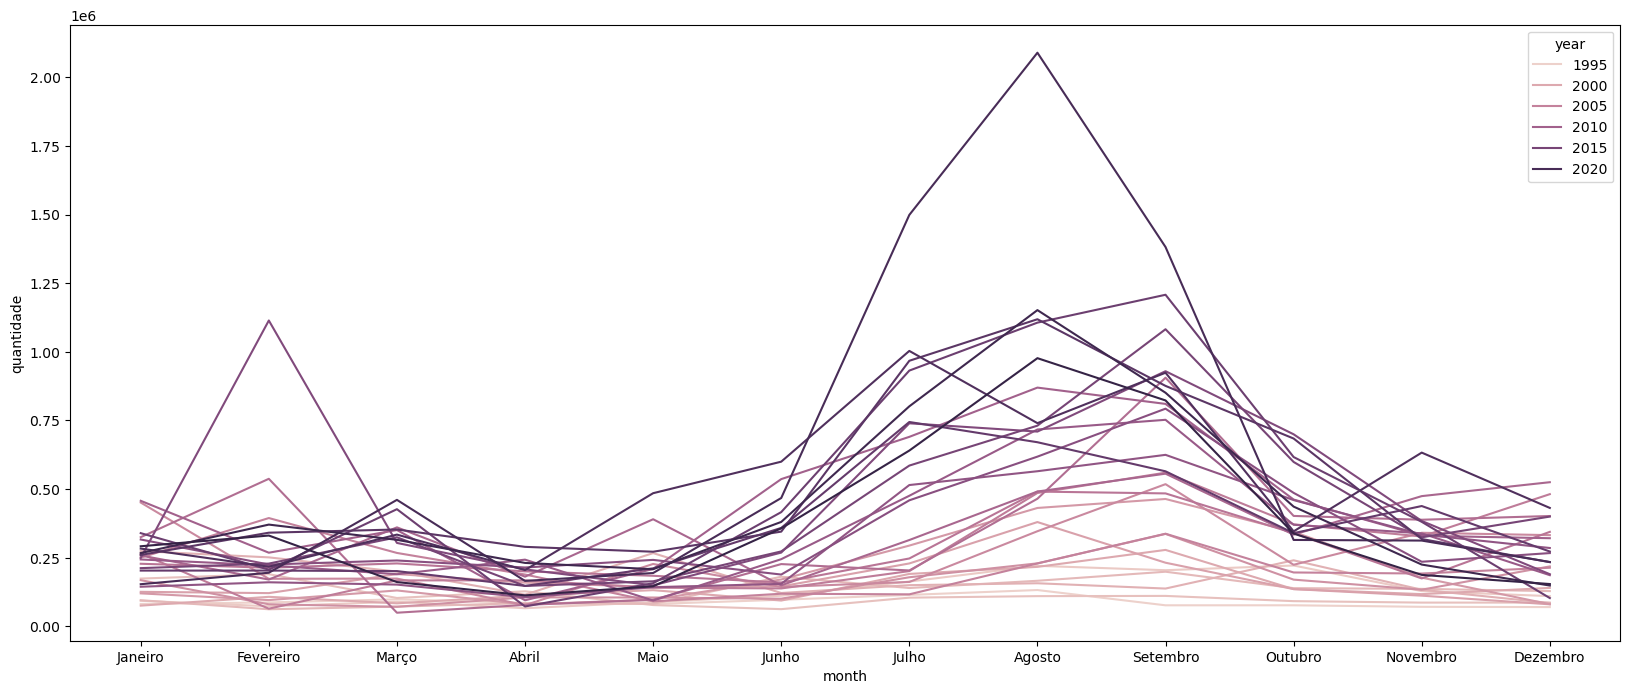

In [87]:
plt.figure(figsize=(20, 8))
sns.lineplot(data=df_merge, y='quantidade', x='month', hue='year')

<AxesSubplot:xlabel='month', ylabel='real'>

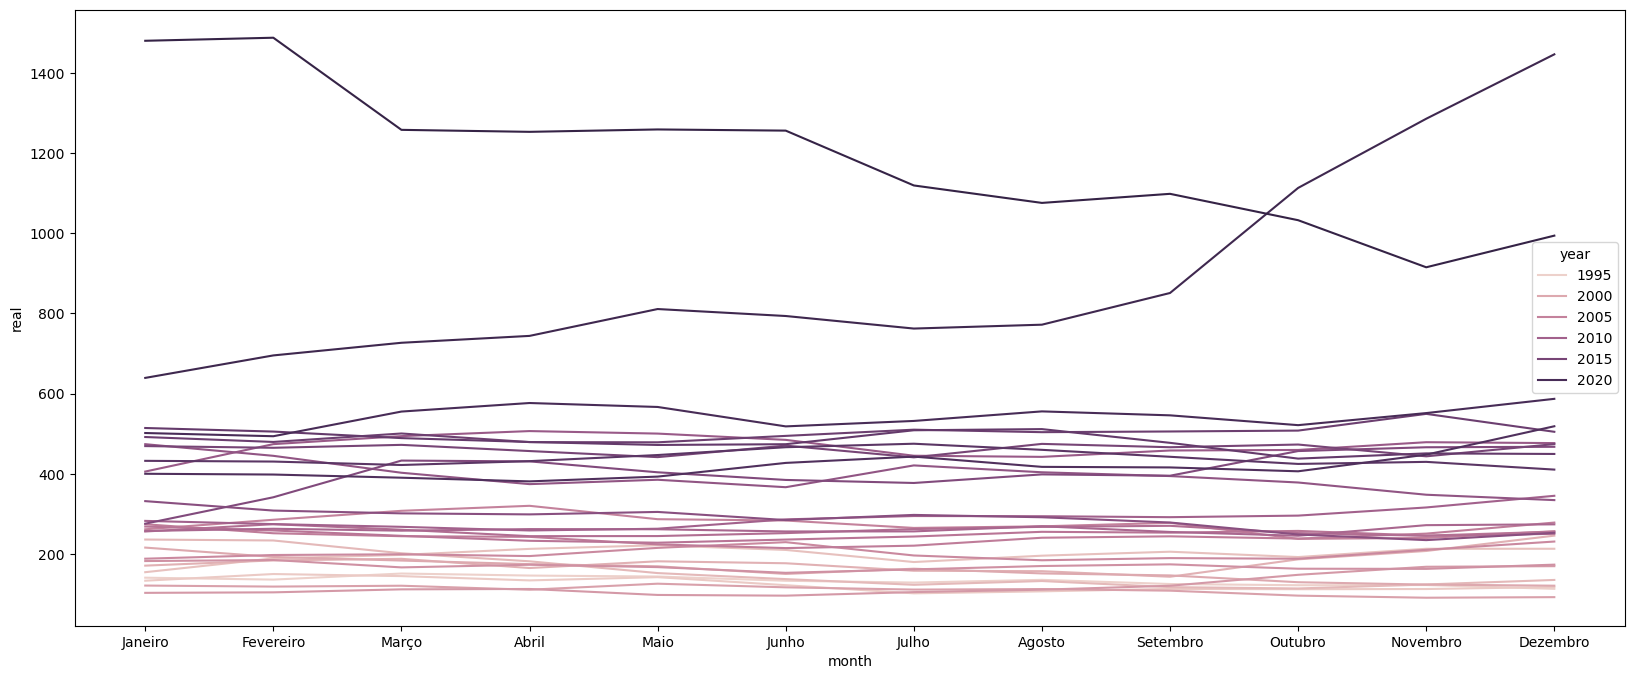

In [89]:
plt.figure(figsize=(20, 8))
sns.lineplot(data=df_merge, y='real', x='month', hue='year')

<AxesSubplot:xlabel='month', ylabel='dolar'>

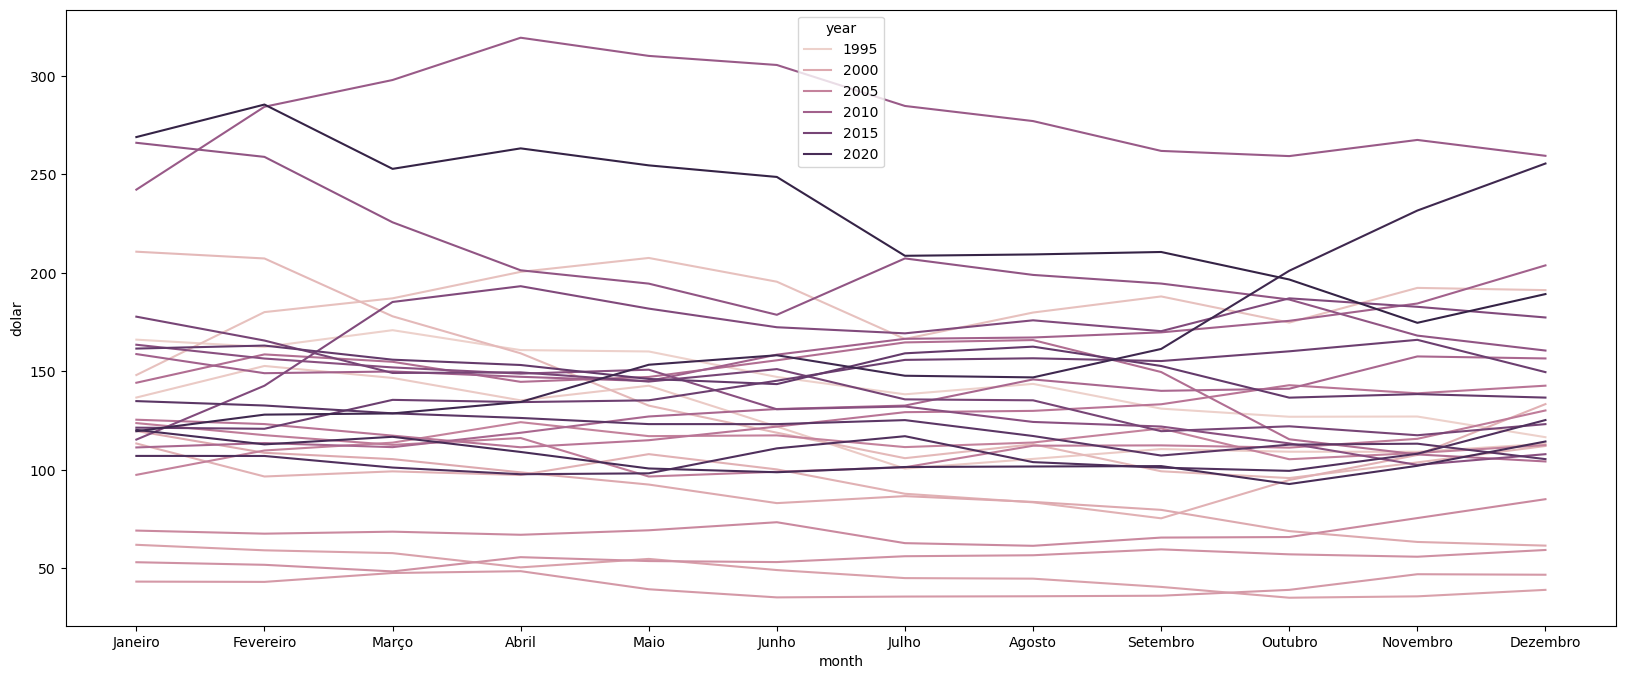

In [90]:
plt.figure(figsize=(20, 8))
sns.lineplot(data=df_merge, y='dolar', x='month', hue='year')

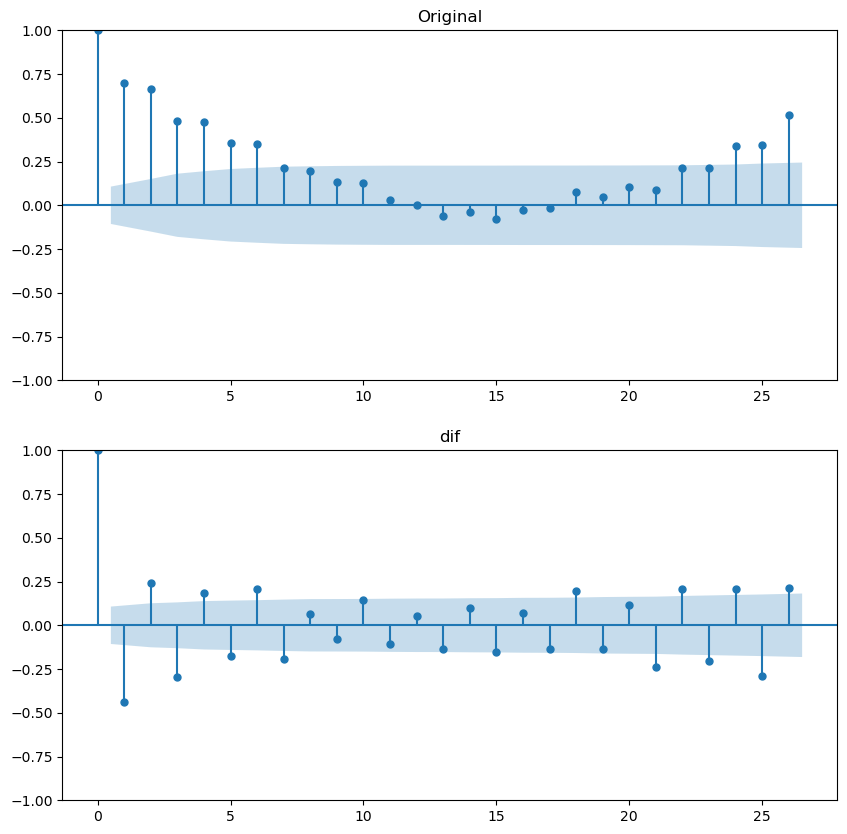

In [93]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_merge['quantidade'], title='Original', ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_acf(df_merge['quantidade'].diff().dropna(), title='dif', ax=ax2)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


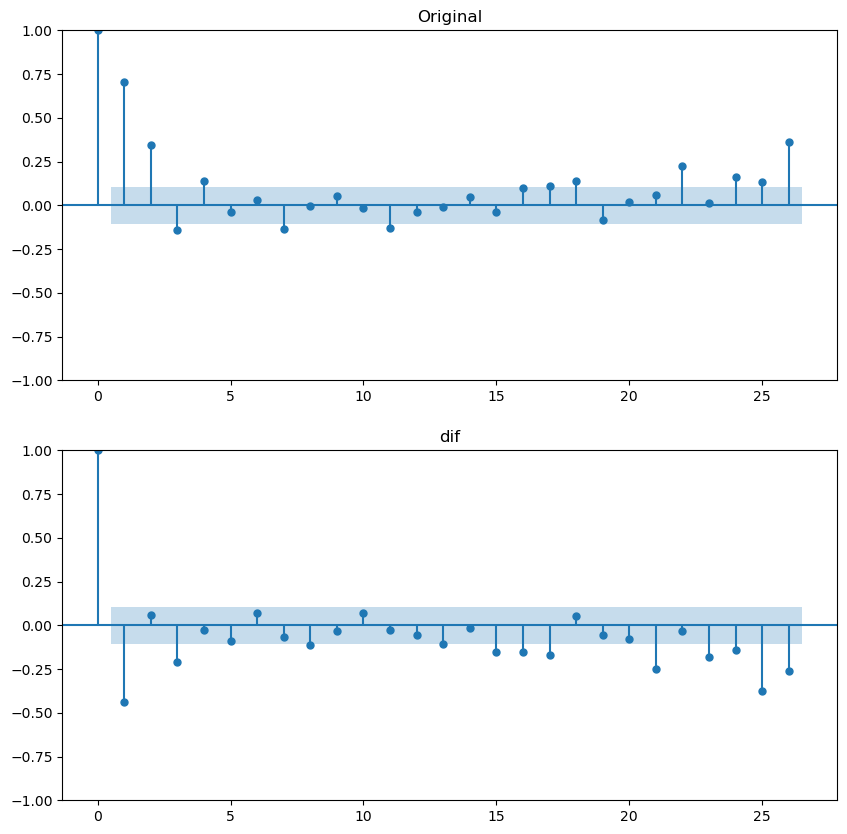

In [94]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(211)
fig = plot_pacf(df_merge['quantidade'], title='Original', ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_merge['quantidade'].diff().dropna(), title='dif', ax=ax2)

In [35]:
data_name = 'dolar'
subtitle = 'teste'
title = 'title'
dict_matadata = {
            data_name:
            {
                'subtitle': subtitle,
                'title': title
            }
        }

In [36]:
dict_matadata

{'dolar': {'subtitle': 'teste', 'title': 'title'}}

In [41]:
import json
content = json.dumps(dict_matadata, indent=4)
with open('metadado.json', 'w') as file:
    file.write(content)